# RNN stock price predictor

Using Recurrent neural network (RNN) and Long short-term memory (LSTM) algorithm, one of deep learning technique, we'll predict selected ticker's future price. 

Note : This is just a basic code, hence it's not suitable to apply in real life market, and any investment should be your own decision also risk you take.





## Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. In RNN, neuron is called cell, information of previously trained cell is used for next cell, hence it is suitable to process sequential data.

[image : RNN]

## Long short-term memory

RNN can store short-term memory, to find correlations of data, it needs long term memory, LSTM is used to support 
this.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


## Stock price predictor


### data cleansing

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
# To prevent TF complier error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Model
import tensorflow as tf
from keras.layers import Dense, SimpleRNN, Dropout, Bidirectional, Activation
from keras.models import Sequential


    
def get_tickers(ticker):
    data = yf.Ticker(ticker)
    x = data.history(period='max', auto_adjust=True)
#     x = pdr.get_data_yahoo(tickers, start=date_from)
    df = pd.DataFrame(x[['Open', 'High', 'Low', 'Volume', 'Close']])
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.rename(columns={'Close' : 'Close'}, inplace=True)
    return df

def Normalizer(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data, 0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [3]:
tickers = 'SPY'
df = get_tickers(tickers)
df

,Open,High,Low,Volume,Close
Date,,,,,
1993-01-29,25.818120,25.818120,25.689672,1003200,25.799770
1993-02-01,25.818125,25.983273,25.818125,480500,25.983273
1993-02-02,25.964916,26.056665,25.909866,201300,26.038315
1993-02-03,26.075019,26.331916,26.056669,529400,26.313566
1993-02-04,26.405305,26.478704,26.111709,531500,26.423655
...,...,...,...,...,...
2021-07-15,434.809998,435.529999,432.720001,55126400,434.750000
2021-07-16,436.010010,436.059998,430.920013,75784700,431.339996
2021-07-19,426.190002,431.410004,421.970001,147987000,424.970001


In [4]:
dfx = Normalizer(df)
dfy = dfx[['Close']]


x = dfx.values.tolist()
y = dfy.values.tolist()

In [5]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7171 entries, 1993-01-29 to 2021-07-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    7171 non-null   float64
 1   High    7171 non-null   float64
 2   Low     7171 non-null   float64
 3   Volume  7171 non-null   float64
 4   Close   7171 non-null   float64
dtypes: float64(5)
memory usage: 336.1 KB


In [6]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7171 entries, 1993-01-29 to 2021-07-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7171 non-null   float64
dtypes: float64(1)
memory usage: 112.0 KB


In [7]:
data_x = []
data_y = []
window_size = 10
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # not including next day close (i+window_size)
    _y = y[i + window_size] # Next day close
    data_x.append(_x)
    data_y.append(_y)

Run `print(_x, "->", _y)` to see _x values added to data_x and _y

In [8]:
print(_x, "->", _y)

[[0.9909204179787647, 0.9923367614152111, 0.9907355965365644, 0.07295380100436143, 0.9936344869992849], [0.9790732203562797, 0.9849887943539722, 0.9810078913136155, 0.1120409138194241, 0.9850337933768394], [0.9881771028627895, 0.9949558072754968, 0.9887851449520326, 0.08746642302924693, 0.9962098459906643], [0.9952174238503065, 0.9986176906055411, 0.9991710857335682, 0.06071540632023724, 0.999999999757041], [0.9971838565447058, 0.9998059525042312, 0.9999999997561991, 0.06074031960879018, 0.9963799350540092], [0.9999999997572298, 0.9999999997574927, 0.9990248111649934, 0.07362071940622333, 0.9979591534324681], [0.9937122604632439, 0.9942040406856304, 0.9936855662056507, 0.06328342677347311, 0.9943390887294363], [0.9966255325003612, 0.9954893262109513, 0.9892971803441649, 0.0870007626680915, 0.9860541794665314], [0.9727854810622939, 0.9842127533556124, 0.9674769729056006, 0.16989462138173228, 0.970577705896295], [0.9715473293333812, 0.986662100378473, 0.9744496420147357, 0.11422960936307

Past 10 days, given data, latest close is 0.8726370803053053, next day close is 0.8677396475977315

### Prepare train / test dataset

In [9]:
# train dataset
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test dataset
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### Build model

In [10]:
# model = keras.Sequential()
# model.add(layers.LSTM(units=10, activation='relu',
#                       return_sequences=True, input_shape=(window_size, 5)))
# model.add(layers.Dropout(0.1))
# model.add(layers.LSTM(units=10, activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(units=1))
# model.summary()

# from keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation
# from keras.models import Sequential
# model = keras.Sequential()
# model.add(layers.LSTM(units=30, activation='relu',
#                       return_sequences=True, input_shape=(window_size, 5)))
# model.add(layers.Dropout(0.1))
# model.add(layers.LSTM(units=40, activation='relu', return_sequences=True))
# model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(units=60, activation='relu', return_sequences=True))
# model.add(layers.Dropout(0.3))
# model.add(layers.LSTM(units=90, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(units=1))
# model.summary()



model = Sequential()

model.add(SimpleRNN(units = 40, activation='relu',
                   return_sequences=True, input_shape=(window_size, 5)))
model.add(Dropout(0.1))
model.add(SimpleRNN(units=40))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 40)            1840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
history = model.fit(train_x, train_y, epochs=30, batch_size=30)
pred_y = model.predict(test_x)

Epoch 1/30
168/168 [==============================] - 24s 6ms/step - loss: 0.0164 - accuracy: 5.9020e-04
Epoch 2/30
168/168 [==============================] - 1s 6ms/step - loss: 9.8026e-04 - accuracy: 3.2577e-04
Epoch 3/30
168/168 [==============================] - 1s 6ms/step - loss: 5.1460e-04 - accuracy: 6.5688e-05
Epoch 4/30
168/168 [==============================] - 1s 6ms/step - loss: 3.7057e-04 - accuracy: 9.2903e-04
Epoch 5/30
168/168 [==============================] - 1s 6ms/step - loss: 2.8439e-04 - accuracy: 3.0836e-04
Epoch 6/30
168/168 [==============================] - 1s 6ms/step - loss: 2.0772e-04 - accuracy: 2.5093e-04
Epoch 7/30
168/168 [==============================] - 1s 6ms/step - loss: 1.8508e-04 - accuracy: 2.7287e-04
Epoch 8/30
168/168 [==============================] - 1s 8ms/step - loss: 1.6623e-04 - accuracy: 4.9902e-04
Epoch 9/30
168/168 [==============================] - 1s 8ms/step - loss: 1.5069e-04 - accuracy: 1.9998e-04
Epoch 10/30
168/168 [==========

### Compare prediction to real

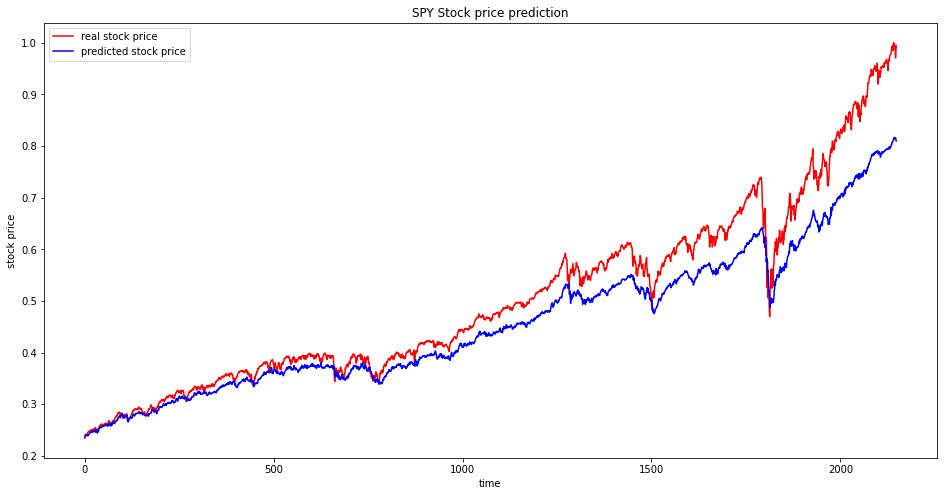

In [12]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y, c='blue', label='predicted stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

## Evaluating Model

In [13]:
# Losses
history.history['loss'];

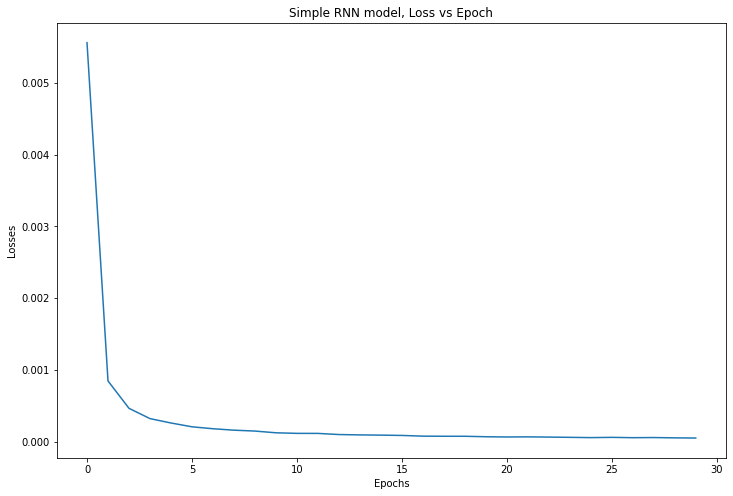

In [17]:
# plot loss vs epochs
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Simple RNN model, Loss vs Epoch')
plt.show()

### Predict tomorrw's close price

In [15]:
print(f'{tickers} tomorrow price : {df.Close[-1]*pred_y[-1]/dfy.Close[-1]}')

SPY tomorrow price : [354.03738]
